## Libraries

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import wandb
from wandb.keras import WandbCallback
import PIL 

wandb.init(project="cats-vs-dogs")

wandb: Currently logged in as: selmee006. Use `wandb login --relogin` to force relogin


## Data loading

In [3]:
# Downloading cats-and-dogs dataset
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-06-07 14:39:34--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.45.56.140, 2600:140b:2:99c::e59, 2600:140b:2:9a7::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.45.56.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  9.78MB/s    in 79s     

2022-06-07 14:40:53 (10.0 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [4]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


## Split training/validation sets

In [5]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    """
    Creates directories for the train and test sets

    Args:
      root_path (string) - the base directory path to create subdirectories from

    Returns:
      None
    """  
    train_dir = os.path.join(root_path, 'training')
    validation_dir = os.path.join(root_path, 'validation')

    # Directory with training cat/dog pictures
    train_cats_dir = os.path.join(train_dir, 'cats')
    train_dogs_dir = os.path.join(train_dir, 'dogs')
    os.makedirs(train_cats_dir)
    os.makedirs(train_dogs_dir)

    # Directory with validation cat/dog pictures
    validation_cats_dir = os.path.join(validation_dir, 'cats')
    validation_dogs_dir = os.path.join(validation_dir, 'dogs')
    os.makedirs(validation_cats_dir)
    os.makedirs(validation_dogs_dir)
    
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs


In [7]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """
    Splits the data into train and test sets

    Args:
      SOURCE_DIR (string): directory path containing the images
      TRAINING_DIR (string): directory path to be used for training
      VALIDATION_DIR (string): directory path to be used for validation
      SPLIT_SIZE (float): proportion of the dataset to be used for training

    Returns:
      None
    """

    files = os.listdir(SOURCE_DIR)
    random.shuffle(files)
    n = round(len(files) * 0.9)

    for filename in files[:n]:
        if os.path.getsize(os.path.join(SOURCE_DIR, filename)) > 0:
            copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(TRAINING_DIR, filename))
        else:
            print("{} is zero length, so ignoring.".format(filename))

    for filename in files[n:]:
        if os.path.getsize(os.path.join(SOURCE_DIR, filename)) > 0:
            copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(VALIDATION_DIR, filename))
        else:
            print("{} is zero length, so ignoring.".format(filename))

In [8]:
# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
    for file in os.scandir(VALIDATION_DOGS_DIR):
        os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11251 images of cats for training
There are 11250 images of dogs for training
There are 1249 images of cats for validation
There are 1250 images of dogs for validation


## Vizialize images

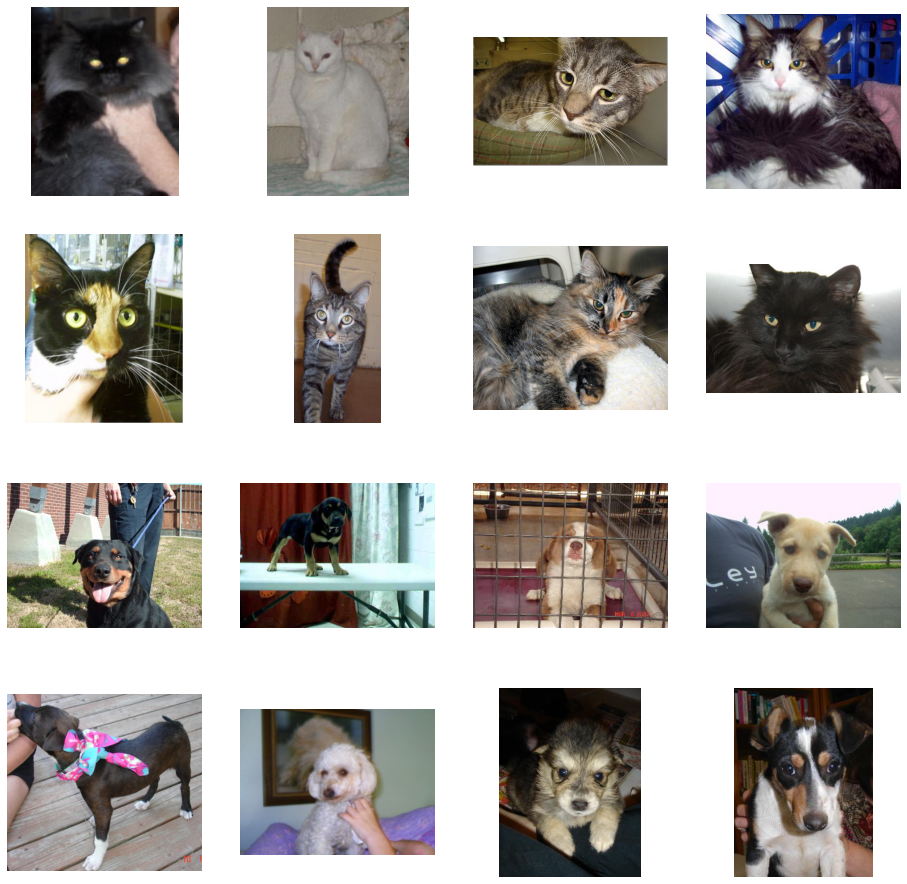

In [9]:
train_cats_names = os.listdir(TRAINING_CATS_DIR)
train_dogs_names = os.listdir(TRAINING_DOGS_DIR)

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cats_pix = [os.path.join(TRAINING_CATS_DIR, fname) 
                for fname in train_cats_names[pic_index-8:pic_index]]
next_dogs_pix = [os.path.join(TRAINING_DOGS_DIR, fname) 
                for fname in train_dogs_names[pic_index-8:pic_index]]

image_array = []
for i, img_path in enumerate(next_cats_pix+next_dogs_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    image_array.append(img)
    plt.imshow(img)

plt.show()

images = [PIL.Image.fromarray(image) for image in image_array]
wandb.log({"examples": [wandb.Image(image) for image in images]})

## Preprocessing images 

In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators

    Args:
      TRAINING_DIR (string): directory path containing the training images
      VALIDATION_DIR (string): directory path containing the testing/validation images

    Returns:
      train_generator, validation_generator - tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

    # Instantiate the ImageDataGenerator class
    validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=20,
                                                                  class_mode='binary',
                                                                  target_size=(150, 150))
    return train_generator, validation_generator

In [11]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


## Build a model

In [12]:
def create_model():
    model = tf.keras.models.Sequential([ 
        # Input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'), 
        # Only 1 output neuron. 
        # It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ])
  
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
    return model


## Training

In [13]:
# Get the untrained model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[WandbCallback()])

2022-06-07 14:41:02.911319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 14:41:02.918934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-07 14:41:02.918950: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-07 14:41:02.919184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Epoch 1/15
1125/1125 [==============================] - 141s 125ms/step - loss: 0.6623 - accuracy: 0.5962 - val_loss: 0.6497 - val_accuracy: 0.6367 - _timestamp: 1654580603.0000 - _runtime: 235.0000
Epoch 2/15
1125/1125 [==============================] - 141s 126ms/step - loss: 0.6030 - accuracy: 0.6728 - val_loss: 0.5275 - val_accuracy: 0.7351 - _timestamp: 1654580746.0000 - _runtime: 378.0000
Epoch 3/15
1125/1125 [==============================] - 139s 123ms/step - loss: 0.5631 - accuracy: 0.7067 - val_loss: 0.5422 - val_accuracy: 0.7359 - _timestamp: 1654580885.0000 - _runtime: 517.0000
Epoch 4/15
1125/1125 [==============================] - 134s 119ms/step - loss: 0.5337 - accuracy: 0.7306 - val_loss: 0.4481 - val_accuracy: 0.7935 - _timestamp: 1654581020.0000 - _runtime: 652.0000
Epoch 5/15
1125/1125 [==============================] - 134s 119ms/step - loss: 0.5149 - accuracy: 0.7463 - val_loss: 0.4432 - val_accuracy: 0.7991 - _timestamp: 1654581154.0000 - _runtime: 786.0000
Epoch

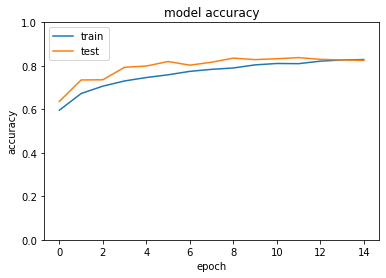

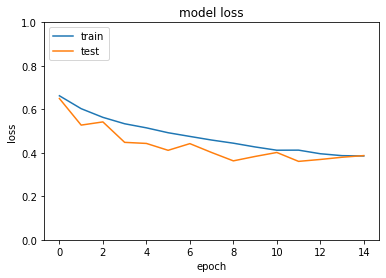

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()

## Visualize feature representations

1/1 [==============================] - 0s 46ms/step


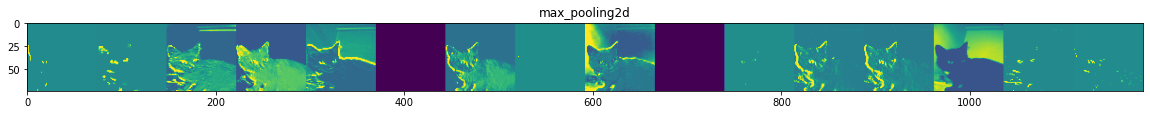

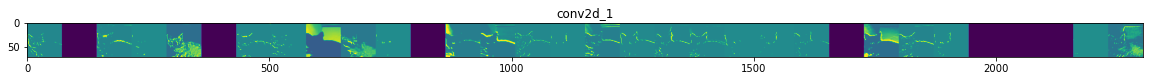

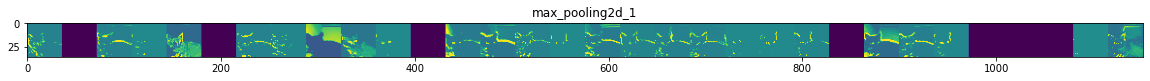

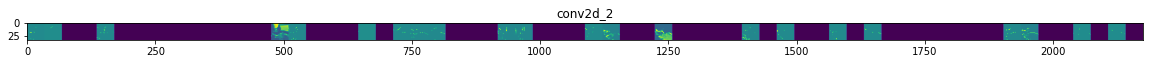

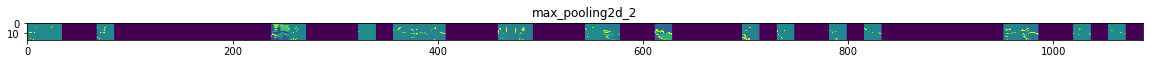

In [28]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cats_img_files = [os.path.join(TRAINING_CATS_DIR, f) for f in train_cats_names]
dogs_img_files = [os.path.join(TRAINING_DOGS_DIR, f) for f in train_dogs_names]
img_path = random.choice(cats_img_files + dogs_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')